- Vehicle: 6554
- OCV open circuit voltage

In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import platform
import logging
import argparse
import trino
import io
import boto3
from itertools import islice
from datetime import datetime, date, timedelta
import pendulum
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Add parent directory to path
repo_path = '/Users/apple/Documents/naarni/repo/dview-naarni-data-platform'
# repo_path = '/home/notebook/prod/nelson/dview-naarni-data-platform'
sys.path.append(os.path.join(repo_path, 'tasks'))

# Import necessary files and its respective functions
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg,drop_table,execute_query
from common.optimizer_logic import optimize_dataframe_memory

# Import business logic functions
from biz_logic.energy_mileage.energy_mileage_daily_v0 import energy_mileage_stats ,impute_odometer_readings

from biz_logic.energy_consumption.energy_consumption_report import energy_consumption_stats

# Configure basic logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Print the Python version being used
print(f"Using Python version: {platform.python_version()}")

Using Python version: 3.13.7


In [3]:
# ---- reporting config (edit ONLY this) ----
TABLE_NAME = "can_parsed_output_100"   # <— change only this

# derived (don’t edit)
REPORT_TABLE = f"adhoc.facts_prod.{TABLE_NAME}"
REPORT_S3_LOCATION = f"s3a://naarni-data-lake/aqua/warehouse/facts_prod.db/{TABLE_NAME}/"

In [4]:
date_str = "2025-10-01"  # Date for which data is to be processed

# Parse the date string as a date object
target_date = datetime.strptime(date_str, "%Y-%m-%d").date()

# Create datetime objects for the start and end of the day in IST
ist_start = datetime.combine(target_date, datetime.min.time())
ist_end = ist_start + timedelta(days=31)

# Convert IST to UTC for the database query
# IST is UTC+5:30, so we subtract 5 hours and 30 minutes
utc_start = ist_start - timedelta(hours=5, minutes=30) 
utc_end = ist_end - timedelta(hours=5, minutes=30)

utc_start_date = utc_start.date()
utc_end_date = utc_end.date()

logging.info(f"🔍 Query window (UTC): {utc_start} → {utc_end}")
logging.info(f"🔍 Query window (IST): {ist_start} → {ist_end}")
logging.info(f"📅 Target date (UTC): {utc_start_date} → {utc_end_date}")

2025-11-14 13:08:56 - INFO - 🔍 Query window (UTC): 2025-09-30 18:30:00 → 2025-10-31 18:30:00
2025-11-14 13:08:56 - INFO - 🔍 Query window (IST): 2025-10-01 00:00:00 → 2025-11-01 00:00:00
2025-11-14 13:08:56 - INFO - 📅 Target date (UTC): 2025-09-30 → 2025-10-31


### AC Fault Code:
1. No_Fault
2. Low_Voltage
3. Outside_Temp_Sensor_Fault
4. High_Voltage
5. Exhaust_Temp_Protection
6. Eva_Temp_Sesnor_Fault
7. AC Communication Fail

### AC Status:
1. Start
2. Stop

### TMS Fault Code:
1. No Fault
2. Water_Sensor_Failure
3. Water_Pump_Failure
4. Water_IN_Sensor_Failure
5. Exhaust_Temp_Protection
6. Low_Water_Level_Alarm
7. LV Undervoltage

### TMS Working Mode:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Low_Coolant
5. Off

### B2T TMS Control Cmd:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Off

In [5]:
import pandas as pd
from datetime import datetime, timedelta
import logging

def fetch_can_parsed_data(
    start_date: str,
    end_date: str,
    vehicle_ids: list = None,
    table_name: str = "facts_prod.can_parsed_output_all",
    chunk_days: int = 1,
):
    """
    Iteratively fetch CAN-parsed data from Trino for the specified date range and optional vehicle IDs.
    Keeps logic clean and avoids joins — purely focused on efficient retrieval.

    Args:
        start_date (str): Start date (YYYY-MM-DD)
        end_date (str): End date (YYYY-MM-DD)
        vehicle_ids (list, optional): List of vehicle IDs. If None, id filter ignored.
        table_name (str): Table to fetch data from (default: facts_prod.can_parsed_output_all)
        chunk_days (int): Number of days to fetch per iteration (default: 1)

    Returns:
        pd.DataFrame: Combined dataframe across all fetched chunks.
    """

    logging.info(f"🚀 Fetching CAN-parsed data from {table_name} ({start_date} → {end_date})")

    # Establish Trino connection
    conn = connect_to_trino(host="trino.naarni.internal",port=80,user="admin",catalog="adhoc",schema="default")

    # --- Optional vehicle filter ---
    id_filter = ""
    if vehicle_ids:
        vehicle_ids_str = ", ".join([f"'{vid}'" for vid in vehicle_ids])
        id_filter = f"AND id IN ({vehicle_ids_str})"

    # --- Convert dates to datetime ---
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")

    # --- Data accumulator ---
    df_list = []
    cur_date = start_dt

    # --- Iterate by day or chunk_days ---
    while cur_date <= end_dt:
        logging.info(f"📆 Fetching data for: {cur_date.date()}")

        query = f"""
            SELECT 
                id,timestamp,dt, 
                vehiclereadycondition, gun_connection_status, ignitionstatus,
                vehicle_speed_vcu,gear_position,bat_soc,soh,total_battery_current,
                pack1_cellmax_temperature, pack1_cell_min_temperature, pack1_maxtemperature_cell_number,  pack1_celltemperature_cellnumber,
                bat_voltage,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage      
            FROM {table_name}
            WHERE dt = DATE('{cur_date:%Y-%m-%d}')
            {id_filter}
        """

        try:
            cur = conn.cursor()
            cur.execute(query)
            rows = cur.fetchall()
            cols = [desc[0] for desc in cur.description]

            chunk_df = pd.DataFrame(rows, columns=cols)
            df_list.append(chunk_df)
            chunk_df.head()

            logging.info(f"✅ {len(chunk_df)} rows fetched for {cur_date.date()}")

        except Exception as e:
            logging.error(f"❌ Error fetching chunk {cur_date.date()}: {e}")

        cur_date += timedelta(days=chunk_days)

    # Close connections
    cur.close()
    conn.close()


    # --- Combine all chunks ---
    df_final = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()
    logging.info(f"🏁 Done — {len(df_final)} total rows fetched from {table_name}")
        
    return df_final

In [6]:
utc_start.strftime("%Y-%m-%d"),utc_end.strftime("%Y-%m-%d")

('2025-09-30', '2025-10-31')

In [7]:
def rename_battery_temp_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renames temperature columns from BCS/TMS naming to standardized names.
    - b2t_battery_max_temp → batt_maxtemp
    - b2t_battery_min_temp → batt_mintemp
    """

    rename_map = {
        "pack1_cellmax_temperature": "batt_maxtemp",
        "pack1_cell_min_temperature": "batt_mintemp",
    }

    existing_cols = [c for c in rename_map if c in df.columns]
    if not existing_cols:
        print("⚠️ No matching temperature columns found to rename.")
        return df

    df = df.rename(columns={c: rename_map[c] for c in existing_cols})
    print(f"✅ Renamed columns: {', '.join(existing_cols)}")
    return df


In [ ]:
df_cpo100 = pd.read_csv('oct25_can_parsed_data.csv')
# df_cpo100 = fetch_can_parsed_data(start_date=utc_start.strftime("%Y-%m-%d"),end_date=utc_end.strftime("%Y-%m-%d"),vehicle_ids=['3','16','18','19','32','42','6','7','9','11','12','13','14','15','20','25','27','28','29','30','31','33','35','41','46'])
df_cpo100 = rename_battery_temp_columns(df_cpo100)
df_cpo100["batt_temp_delta"] = (pd.to_numeric(df_cpo100["batt_maxtemp"], errors="coerce") -pd.to_numeric(df_cpo100["batt_mintemp"], errors="coerce"))
df_cpo100 = df_cpo100[(df_cpo100.timestamp >= utc_start.strftime("%Y-%m-%d")) & (df_cpo100.timestamp <= utc_end.strftime("%Y-%m-%d"))].copy()
df_cpo100.head()

,Unnamed: 0,id,timestamp,dt,vehiclereadycondition,gun_connection_status,ignitionstatus,vehicle_speed_vcu,gear_position,bat_soc,soh,total_battery_current,pack1_cellmax_temperature,pack1_cell_min_temperature,pack1_maxtemperature_cell_number,pack1_celltemperature_cellnumber,bat_voltage,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage
0,0,7,2025-09-30 12:57:39.005,2025-09-30,1.0,0.0,1.0,21.335938,2.0,44.4,98.0,-22.3,28.0,26.0,81.0,9.0,630.0,38.0,3.284,28.0,3.281
1,1,7,2025-09-30 12:57:42.005,2025-09-30,1.0,0.0,1.0,14.765625,2.0,44.4,98.0,-48.6,28.0,26.0,81.0,9.0,629.6,302.0,3.282,47.0,3.279
2,2,7,2025-09-30 12:57:45.184,2025-09-30,1.0,0.0,1.0,9.007812,2.0,44.4,98.0,-8.8,28.0,26.0,81.0,9.0,629.6,423.0,3.282,120.0,3.277
3,3,7,2025-09-30 12:57:47.065,2025-09-30,1.0,0.0,1.0,8.031250,2.0,44.4,98.0,-4.7,28.0,26.0,81.0,9.0,628.7,38.0,3.277,145.0,3.273
4,4,7,2025-09-30 12:57:49.926,2025-09-30,1.0,0.0,1.0,5.984375,2.0,44.4,NaN,-0.4,NaN,NaN,NaN,NaN,628.8,NaN,NaN,NaN,NaN


In [9]:
# df_cpo100.to_csv('oct25_can_parsed_data.csv')

In [10]:
df_cpo100.id.unique()

array([ 7,  6, 12, 16, 18, 13, 11, 14, 19, 27,  9, 15,  3, 33, 28, 29, 32,
       42, 20, 25, 31, 30, 46])

In [ ]:
display(len(df_cpo100))
display(df_cpo100.head(10))

✅ Renamed columns: pack1_cellmax_temperature, pack1_cell_min_temperature


23380898

,Unnamed: 0,id,timestamp,dt,vehiclereadycondition,gun_connection_status,ignitionstatus,vehicle_speed_vcu,gear_position,bat_soc,soh,total_battery_current,batt_maxtemp,batt_mintemp,pack1_maxtemperature_cell_number,pack1_celltemperature_cellnumber,bat_voltage,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,batt_temp_delta
0,0,7,2025-09-30 12:57:39.005,2025-09-30,1.0,0.0,1.0,21.335938,2.0,44.4,98.0,-22.3,28.0,26.0,81.0,9.0,630.0,38.0,3.284,28.0,3.281,2.0
1,1,7,2025-09-30 12:57:42.005,2025-09-30,1.0,0.0,1.0,14.765625,2.0,44.4,98.0,-48.6,28.0,26.0,81.0,9.0,629.6,302.0,3.282,47.0,3.279,2.0
2,2,7,2025-09-30 12:57:45.184,2025-09-30,1.0,0.0,1.0,9.007812,2.0,44.4,98.0,-8.8,28.0,26.0,81.0,9.0,629.6,423.0,3.282,120.0,3.277,2.0
3,3,7,2025-09-30 12:57:47.065,2025-09-30,1.0,0.0,1.0,8.031250,2.0,44.4,98.0,-4.7,28.0,26.0,81.0,9.0,628.7,38.0,3.277,145.0,3.273,2.0
4,4,7,2025-09-30 12:57:49.926,2025-09-30,1.0,0.0,1.0,5.984375,2.0,44.4,NaN,-0.4,NaN,NaN,NaN,NaN,628.8,NaN,NaN,NaN,NaN,NaN
5,5,7,2025-09-30 12:57:51.704,2025-09-30,1.0,0.0,NaN,3.148438,2.0,44.4,98.0,3.5,28.0,26.0,81.0,9.0,629.0,38.0,3.279,145.0,3.275,2.0
6,6,7,2025-09-30 12:57:53.384,2025-09-30,1.0,0.0,1.0,0.187500,2.0,44.4,NaN,3.3,NaN,NaN,NaN,NaN,629.1,NaN,NaN,NaN,NaN,NaN
7,7,7,2025-09-30 12:57:54.964,2025-09-30,1.0,0.0,1.0,0.000000,2.0,44.4,98.0,3.3,28.0,26.0,81.0,9.0,629.1,38.0,3.279,145.0,3.275,2.0
8,8,7,2025-09-30 12:57:56.464,2025-09-30,1.0,0.0,1.0,0.000000,2.0,44.4,98.0,3.3,28.0,26.0,81.0,9.0,629.1,280.0,3.279,124.0,3.276,2.0
9,9,7,2025-09-30 12:57:58.004,2025-09-30,1.0,0.0,1.0,0.000000,2.0,44.4,NaN,3.4,NaN,NaN,NaN,NaN,629.2,NaN,NaN,NaN,NaN,NaN


In [12]:
def calc_temp_delta_stats(df: pd.DataFrame, lower: float = 5.0, upper: float = 8.0, plot: bool = True) -> dict:
    """
    Calculate and visualize the percentage of time the battery temperature delta (batt_temp_delta)
    lies below, within, and above a specified range.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'timestamp' and 'batt_temp_delta' columns.
    lower : float, default 5.0
        Lower threshold for delta range (°C).
    upper : float, default 8.0
        Upper threshold for delta range (°C).
    plot : bool, default True
        If True, display a line plot with shaded zone and annotated percentages.

    Returns
    -------
    dict
        Dictionary with percentage time in each range (<lower, [lower–upper], >upper).
    """
    if "timestamp" not in df.columns or "batt_temp_delta" not in df.columns:
        raise KeyError("DataFrame must include 'timestamp' and 'batt_temp_delta' columns.")

    df = df.sort_values("timestamp").reset_index(drop=True)
    df["delta_time_sec"] = df["timestamp"].diff().dt.total_seconds()

    # Masks
    mask_low = df["batt_temp_delta"] < lower
    mask_mid = df["batt_temp_delta"].between(lower, upper, inclusive="both")
    mask_high = df["batt_temp_delta"] > upper

    # Durations
    total_duration = df["delta_time_sec"].sum(skipna=True)
    dur_low = df.loc[mask_low, "delta_time_sec"].sum(skipna=True)
    dur_mid = df.loc[mask_mid, "delta_time_sec"].sum(skipna=True)
    dur_high = df.loc[mask_high, "delta_time_sec"].sum(skipna=True)

    # Percentages
    pct_low = (dur_low / total_duration) * 100 if total_duration else np.nan
    pct_mid = (dur_mid / total_duration) * 100 if total_duration else np.nan
    pct_high = (dur_high / total_duration) * 100 if total_duration else np.nan

    summary = {
        f"<{lower}°C": round(pct_low, 2),
        f"{lower}–{upper}°C": round(pct_mid, 2),
        f">{upper}°C": round(pct_high, 2)
    }

    # --- Print summary ---
    print("ΔT range summary:")
    print(f"<{lower}°C  = {summary[f'<{lower}°C']:.2f}%")
    print(f"{lower}–{upper}°C = {summary[f'{lower}–{upper}°C']:.2f}%")
    print(f">{upper}°C  = {summary[f'>{upper}°C']:.2f}%")

    # --- Plot section ---
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(df["timestamp"], df["batt_temp_delta"], color="tab:blue", linewidth=1.2, label="ΔT (°C)")
        plt.axhspan(lower, upper, color="lightgreen", alpha=0.3, label=f"{lower}–{upper}°C zone")
        plt.title("Battery Temperature Delta Over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("ΔT (°C)")
        plt.legend()

        # Annotate summary on the plot
        text = (
            f"<{lower}°C  = {summary[f'<{lower}°C']:.1f}%\n"
            f"{lower}–{upper}°C = {summary[f'{lower}–{upper}°C']:.1f}%\n"
            f">{upper}°C  = {summary[f'>{upper}°C']:.1f}%"
        )
        plt.text(
            0.98, 0.05, text,
            transform=plt.gca().transAxes,
            fontsize=10,
            va="bottom", ha="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        plt.show()

    return summary


# stats = calc_temp_delta_stats(df_with_state, lower=5, upper=8, plot=True)
# print(stats)


In [13]:
def calc_temp_safety_stats(df: pd.DataFrame, lower: float = 20.0, upper: float = 35.0, plot: bool = True) -> dict:
    """
    Calculate and visualize the percentage and duration where both batt_maxtemp and batt_mintemp
    lie within the specified safe temperature range.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'timestamp', 'batt_mintemp', and 'batt_maxtemp' columns.
    lower : float, default 20.0
        Lower threshold of safe temperature zone (°C).
    upper : float, default 35.0
        Upper threshold of safe temperature zone (°C).
    plot : bool, default True
        Whether to show the plot with SAFE/EVALUATE summary overlay.

    Returns
    -------
    dict
        Summary containing SAFE/EVALUATE durations and percentages.
    """
    required_cols = {"timestamp", "batt_mintemp", "batt_maxtemp"}
    if not required_cols.issubset(df.columns):
        raise KeyError(f"Missing required columns: {required_cols - set(df.columns)}")

    # --- Preprocess ---
    df = df.sort_values("timestamp").reset_index(drop=True)
    df["delta_time_sec"] = df["timestamp"].diff().dt.total_seconds()

    # --- Label SAFE vs EVALUATE ---
    df["temp_status"] = np.where(
        (df["batt_mintemp"].between(lower, upper, inclusive="both")) &
        (df["batt_maxtemp"].between(lower, upper, inclusive="both")),
        "SAFE", "EVALUATE"
    )

    # --- Duration Calculations ---
    total_duration = df["delta_time_sec"].sum(skipna=True)
    safe_duration = df.loc[df["temp_status"] == "SAFE", "delta_time_sec"].sum(skipna=True)
    eval_duration = total_duration - safe_duration

    # --- Percentage Calculations ---
    safe_percent = (safe_duration / total_duration * 100) if total_duration else np.nan
    eval_percent = (eval_duration / total_duration * 100) if total_duration else np.nan

    result = {
        "safe_range": f"{lower}–{upper}°C",
        "safe_duration_sec": round(safe_duration, 2),
        "evaluate_duration_sec": round(eval_duration, 2),
        "safe_percent": round(safe_percent, 2),
        "evaluate_percent": round(eval_percent, 2)
    }

    # --- Print textual summary ---
    print(f"\nBattery Temperature Safety Summary ({lower}–{upper}°C):")
    print(f"SAFE      = {result['safe_percent']:.2f}%  ({result['safe_duration_sec']:.2f} sec)")
    print(f"EVALUATE  = {result['evaluate_percent']:.2f}%  ({result['evaluate_duration_sec']:.2f} sec)")

    # --- Visualization ---
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(df["timestamp"], df["batt_mintemp"], color="tab:blue", label="Min Temp (°C)", alpha=0.8)
        plt.plot(df["timestamp"], df["batt_maxtemp"], color="tab:red", label="Max Temp (°C)", alpha=0.8)
        plt.axhspan(lower, upper, color="lightgreen", alpha=0.3, label=f"SAFE Zone ({lower}–{upper}°C)")

        # Color-coded SAFE/EVALUATE timeline bar
        for i in range(len(df) - 1):
            color = "green" if df.loc[i, "temp_status"] == "SAFE" else "orange"
            plt.axvspan(df.loc[i, "timestamp"], df.loc[i + 1, "timestamp"], ymin=0, ymax=0.02, color=color, alpha=0.9)

        plt.title(f"Battery Temperature Safety Timeline ({lower}–{upper}°C)")
        plt.xlabel("Timestamp")
        plt.ylabel("Temperature (°C)")
        plt.legend(loc="upper right")

        # --- Add summary box on the graph ---
        summary_text = (
            f"SAFE      = {result['safe_percent']:.2f}%  ({result['safe_duration_sec']:.2f} sec)\n"
            f"EVALUATE  = {result['evaluate_percent']:.2f}%  ({result['evaluate_duration_sec']:.2f} sec)"
        )
        plt.text(
            0.98, 0.05, summary_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            va="bottom", ha="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        plt.show()

    return result


# safety_summary = calc_temp_safety_stats(df_with_state, lower=20, upper=35, plot=True)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calc_cooling_response_time(df: pd.DataFrame, threshold: float = 35.0, plot: bool = True) -> dict:
    """
    Calculate and visualize response times for batt_maxtemp to cool down
    from above the threshold to below it.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'timestamp' and 'batt_maxtemp' columns.
    threshold : float, default 35.0
        Temperature threshold (°C) for cooling evaluation.
    plot : bool, default True
        Whether to display the graph.

    Returns
    -------
    dict
        Contains number of events and 95th/99th percentile response times (seconds).
    """
    if "timestamp" not in df.columns or "batt_maxtemp" not in df.columns:
        raise KeyError("DataFrame must include 'timestamp' and 'batt_maxtemp' columns.")

    # --- Preprocess ---
    df = df.sort_values("timestamp").reset_index(drop=True)
    df["batt_maxtemp"] = pd.to_numeric(df["batt_maxtemp"], errors="coerce")

    temp = df["batt_maxtemp"]
    ts = df["timestamp"]

    # --- Detect threshold crossings ---
    above = temp > threshold
    below = temp < threshold

    cooling_events = []
    event_windows = []  # to mark shading
    in_event = False
    start_idx = None

    for i in range(1, len(df)):
        # Start of a new cooling phase
        if above.iloc[i-1] and not in_event:
            start_idx = i-1
            in_event = True

        # End of a cooling phase
        if in_event and below.iloc[i]:
            end_idx = i
            t1, t2 = ts.iloc[start_idx], ts.iloc[end_idx]
            dt = (t2 - t1).total_seconds()
            if dt > 0:
                cooling_events.append(dt)
                event_windows.append((t1, t2))
            in_event = False
            start_idx = None

    cooling_series = pd.Series(cooling_events, name="cooling_durations_sec")

    # --- Percentile Summary ---
    p95 = cooling_series.quantile(0.95) if not cooling_series.empty else np.nan
    p99 = cooling_series.quantile(0.99) if not cooling_series.empty else np.nan

    result = {
        "threshold_degC": threshold,
        "num_events": len(cooling_series),
        "p95_response_time_sec": round(p95, 2) if not np.isnan(p95) else np.nan,
        "p99_response_time_sec": round(p99, 2) if not np.isnan(p99) else np.nan,
        "all_durations_sec": cooling_series.tolist()
    }

    # --- Print summary ---
    print(f"\nCooling Response Time Summary (>{threshold}°C → <{threshold}°C):")
    print(f"Number of events: {len(cooling_series)}")
    print(f"95th percentile response time: {result['p95_response_time_sec']} sec")
    print(f"99th percentile response time: {result['p99_response_time_sec']} sec")

    # --- Visualization ---
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(ts, temp, color="tab:red", label="batt_maxtemp (°C)")
        plt.axhline(threshold, color="black", linestyle="--", linewidth=1, label=f"Threshold {threshold}°C")

        # Highlight cooling events
        for (start, end) in event_windows:
            plt.axvspan(start, end, color="lightblue", alpha=0.4)

        plt.title(f"Cooling Response Analysis (>{threshold}°C → <{threshold}°C)")
        plt.xlabel("Timestamp")
        plt.ylabel("Max Battery Temp (°C)")
        plt.legend(loc="upper right")

        # --- Inline summary box ---
        summary_text = (
            f"Events: {len(cooling_series)}\n"
            f"95th percentile: {result['p95_response_time_sec']} sec\n"
            f"99th percentile: {result['p99_response_time_sec']} sec"
        )
        plt.text(
            0.98, 0.05, summary_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            va="bottom", ha="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        plt.show()

    return result


# cooling_summary = calc_cooling_response_time(df_with_state, threshold=35, plot=True)

In [15]:
# rename_map = {
#     "b2t_battery_min_temp": "batt_mintemp",
#     "b2t_battery_max_temp": "batt_maxtemp",        
# }
# df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

Processing Vehicle 3...
ΔT range summary:
<5°C  = 55.13%
5–8°C = 22.62%
>8°C  = 0.00%


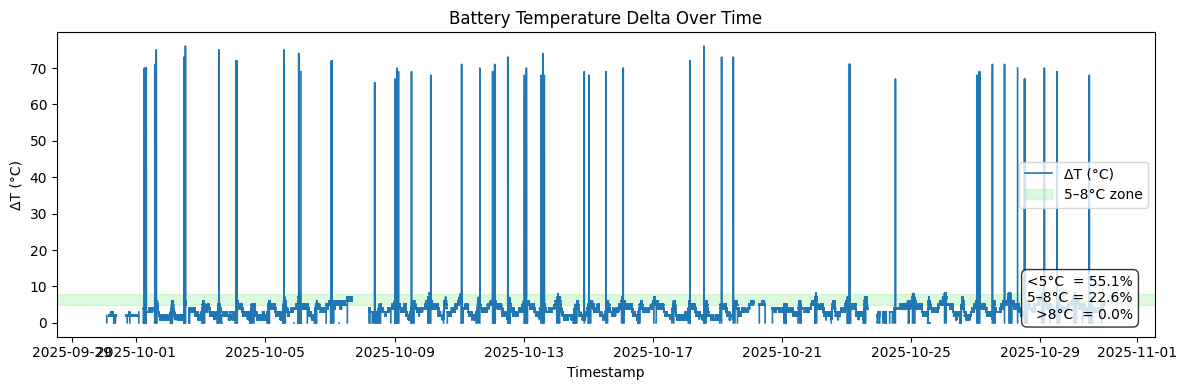


Battery Temperature Safety Summary (20–35°C):
SAFE      = 64.09%  (1711692.02 sec)
EVALUATE  = 35.91%  (958992.23 sec)


KeyboardInterrupt: 

In [ ]:
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.platypus import Paragraph, Spacer, SimpleDocTemplate, Table, TableStyle, Image, PageBreak
from reportlab.lib import colors
from datetime import datetime

def generate_fleet_pdf_report(df_all: pd.DataFrame, output_path="Fleet_Temperature_Report.pdf", fleet_name="EV Fleet"):
    """
    Generate a professional multi-page PDF report summarizing battery temperature analysis
    across multiple vehicles using ReportLab and Matplotlib.
    """

    # --- Ensure timestamp dtype ---
    df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])

    # --- Step 1: Prepare output directory ---
    temp_dir = "temp_figs"
    os.makedirs(temp_dir, exist_ok=True)

    all_summaries = []

    # --- Step 2: Loop through each vehicle ---
    for vid, df_vehicle in df_all.groupby("id"):
        print(f"Processing Vehicle {vid}...")

        df_vehicle = df_vehicle.sort_values("timestamp")

        # ΔT graph
        delta_stats = calc_temp_delta_stats(df_vehicle, lower=5, upper=8, plot=True)
        delta_path = f"{temp_dir}/vehicle_{vid}_delta.png"
        plt.savefig(delta_path, bbox_inches="tight")
        plt.close()

        # Safety graph
        safety_stats = calc_temp_safety_stats(df_vehicle, lower=20, upper=35, plot=True)
        safety_path = f"{temp_dir}/vehicle_{vid}_safety.png"
        plt.savefig(safety_path, bbox_inches="tight")
        plt.close()

        # Cooling graph
        cooling_stats = calc_cooling_response_time(df_vehicle, threshold=35, plot=True)
        cooling_path = f"{temp_dir}/vehicle_{vid}_cooling.png"
        plt.savefig(cooling_path, bbox_inches="tight")
        plt.close()

        # Combine summary
        summary = {
            "vehicle_id": vid,
            **delta_stats,
            **safety_stats,
            "cool_events": cooling_stats["num_events"],
            "cool_p95_sec": cooling_stats["p95_response_time_sec"],
            "cool_p99_sec": cooling_stats["p99_response_time_sec"],
        }
        all_summaries.append(summary)

    df_summary = pd.DataFrame(all_summaries)

    # --- Step 3: Create PDF Document ---
    doc = SimpleDocTemplate(output_path, pagesize=A4,
                            rightMargin=40, leftMargin=40, topMargin=40, bottomMargin=40)
    elements = []

    # --- Cover Page ---
    cover_title = f"<para align=center><b><font size=18>{fleet_name} - Battery Temperature Analysis</font></b></para>"
    report_date = f"<para align=center><font size=11>Report Generated: {datetime.now().strftime('%d %b %Y, %H:%M')}</font></para>"
    subtitle = "<para align=center><font size=12>Fleet Thermal Safety, Spread, and Cooling Response Analysis</font></para>"
    elements += [Paragraph(cover_title, None), Spacer(1, 0.2*inch),
                 Paragraph(subtitle, None), Spacer(1, 0.4*inch),
                 Paragraph(report_date, None), PageBreak()]

    # --- Fleet Summary Table ---
    elements.append(Paragraph("<b>Fleet-Level Summary</b>", None))
    summary_data = [df_summary.columns.tolist()] + df_summary.round(2).values.tolist()
    t = Table(summary_data, repeatRows=1)
    t.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.black),
        ("ALIGN", (0, 0), (-1, -1), "CENTER"),
        ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
        ("FONTSIZE", (0, 0), (-1, -1), 9)
    ]))
    elements += [Spacer(1, 0.2*inch), t, PageBreak()]

    # --- Individual Vehicle Reports ---
    for vid, row in df_summary.iterrows():
        elements.append(Paragraph(f"<b>Vehicle ID: {int(row['vehicle_id'])}</b>", None))
        elements.append(Spacer(1, 0.1*inch))

        # Summary text
        stats_text = f"""
        <font size=10>
        ΔT (5–8°C)     : {row.get('5–8°C', 'NA')}%<br/>
        SAFE (20–35°C) : {row.get('safe_percent', 'NA')}%<br/>
        EVALUATE       : {row.get('evaluate_percent', 'NA')}%<br/>
        Cooling Events : {row.get('cool_events', 'NA')}<br/>
        95th Percentile Cooling : {row.get('cool_p95_sec', 'NA')} sec<br/>
        99th Percentile Cooling : {row.get('cool_p99_sec', 'NA')} sec<br/>
        </font>
        """
        elements.append(Paragraph(stats_text, None))
        elements.append(Spacer(1, 0.2*inch))

        # Add figures
        for fig_path, label in [
            (f"{temp_dir}/vehicle_{int(row['vehicle_id'])}_delta.png", "Temperature Delta (ΔT)"),
            (f"{temp_dir}/vehicle_{int(row['vehicle_id'])}_safety.png", "Safety (20–35°C)"),
            (f"{temp_dir}/vehicle_{int(row['vehicle_id'])}_cooling.png", "Cooling Response (>35°C → <35°C)"),
        ]:
            if os.path.exists(fig_path):
                elements.append(Paragraph(f"<b>{label}</b>", None))
                elements.append(Spacer(1, 0.1*inch))
                elements.append(Image(fig_path, width=6.5*inch, height=3.0*inch))
                elements.append(Spacer(1, 0.2*inch))

        elements.append(PageBreak())

    # --- Build PDF ---
    doc.build(elements)
    print(f"\n✅ Fleet PDF report generated: {output_path}")

    # Clean up temporary figures
    for f in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, f))
    os.rmdir(temp_dir)

    return df_summary


# df["timestamp"] = pd.to_datetime(df["timestamp"])
# fleet_summary = generate_fleet_pdf_report(
#     df_cpo100,
#     output_path="Fleet_Thermal_Report.pdf",
#     fleet_name="Electric Bus Fleet - October 2025"
# )

In [ ]:
wait

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def analyze_battery_conditions(df: pd.DataFrame, output_pdf: str = "battery_conditions_analysis.pdf"):
    """
    Analyze battery max temperature, temperature delta, and voltage delta distributions
    across operation modes (DRIVE vs CHARGING), and export tabulated results to a PDF.
    """

    # --- Ensure required columns exist ---
    required_cols = ["mode", "batt_maxtemp", "batt_mintemp", "cell_max_voltage", "cell_min_voltage"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    # --- Derived variables ---
    df = df.copy()
    df["temp_delta"] = df["batt_maxtemp"] - df["batt_mintemp"]
    df["volt_delta_mv"] = (df["cell_max_voltage"] - df["cell_min_voltage"]) * 1000  # volts → mV

    # --- (1) Battery max temperature buckets ---
    temp_bins = [-np.inf, 28, 32, 35, 40, np.inf]
    temp_labels = ["<28", "28–32", "32–35", "35–40", ">40"]
    df["temp_bucket"] = pd.cut(df["batt_maxtemp"], bins=temp_bins, labels=temp_labels)

    # --- (2) ΔT buckets ---
    delta_bins = [-np.inf, 2, 5, 8, np.inf]
    delta_labels = ["<2", "2–5", "5–8", ">8"]
    df["temp_delta_bucket"] = pd.cut(df["temp_delta"], bins=delta_bins, labels=delta_labels)

    # --- (3) Voltage delta buckets ---
    volt_bins = [0, 10, 20, 30, np.inf]
    volt_labels = ["0–10", "10–20", "20–30", ">30"]
    df["volt_delta_bucket"] = pd.cut(df["volt_delta_mv"], bins=volt_bins, labels=volt_labels)

    # --- Prepare aggregation results ---
    results = {}
    for mode, subset in df.groupby("mode"):
        results[mode] = {
            "Battery Max Temp (%)": (subset["temp_bucket"].value_counts(normalize=True) * 100).round(2),
            "ΔT (°C) Range (%)": (subset["temp_delta_bucket"].value_counts(normalize=True) * 100).round(2),
            "Voltage Δ (mV) (%)": (subset["volt_delta_bucket"].value_counts(normalize=True) * 100).round(2),
        }

    # --- Convert to tabular DataFrames ---
    temp_df = pd.concat({k: v["Battery Max Temp (%)"] for k, v in results.items()}, axis=1)
    delta_df = pd.concat({k: v["ΔT (°C) Range (%)"] for k, v in results.items()}, axis=1)
    volt_df = pd.concat({k: v["Voltage Δ (mV) (%)"] for k, v in results.items()}, axis=1)

    # --- Export summary tables to PDF ---
    with PdfPages(output_pdf) as pdf:
        for title, table_df in {
            "Battery Max Temperature Distribution (%)": temp_df,
            "Temperature Delta Distribution (°C)": delta_df,
            "Voltage Delta Distribution (mV)": volt_df,
        }.items():
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.axis("off")
            table = ax.table(
                cellText=table_df.fillna(0).values,
                rowLabels=table_df.index,
                colLabels=table_df.columns,
                cellLoc="center",
                loc="center"
            )
            table.scale(1, 1.3)
            ax.set_title(title, fontsize=12, fontweight="bold")
            pdf.savefig(fig)
            plt.close(fig)

    print(f"\n✅ PDF created: {output_pdf}")
    return temp_df, delta_df, volt_df


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def analyze_battery_conditions_vehiclewise(
    df: pd.DataFrame,
    output_pdf: str = "battery_conditions_vehiclewise.pdf"
):
    """
    Vehicle-wise battery condition analysis.
    Returns a dict: {vehicle_id: {temp_df, delta_df, volt_df}}
    And also exports a PDF with one page per vehicle.
    """

    required = ["id", "mode", "batt_maxtemp", "batt_mintemp",
                "cell_max_voltage", "cell_min_voltage"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    df = df.copy()
    df["temp_delta"] = df["batt_maxtemp"] - df["batt_mintemp"]
    df["volt_delta_mv"] = (df["cell_max_voltage"] - df["cell_min_voltage"]) * 1000

    # Bucket definitions
    temp_bins = [-np.inf, 28, 32, 35, 40, np.inf]
    temp_labels = ["<28", "28–32", "32–35", "35–40", ">40"]

    delta_bins = [-np.inf, 2, 5, 8, np.inf]
    delta_labels = ["<2", "2–5", "5–8", ">8"]

    volt_bins = [0, 10, 20, 30, np.inf]
    volt_labels = ["0–10", "10–20", "20–30", ">30"]

    df["temp_bucket"] = pd.cut(df["batt_maxtemp"], bins=temp_bins, labels=temp_labels)
    df["temp_delta_bucket"] = pd.cut(df["temp_delta"], bins=delta_bins, labels=delta_labels)
    df["volt_delta_bucket"] = pd.cut(df["volt_delta_mv"], bins=volt_bins, labels=volt_labels)

    # Container for ALL VEHICLES
    vehicle_results = {}

    with PdfPages(output_pdf) as pdf:
        for vid, group in df.groupby("id"):

            # Compute distributions per mode
            mode_results = {}
            for mode, subset in group.groupby("mode"):
                mode_results[mode] = {
                    "Battery Max Temp (%)": (subset["temp_bucket"].value_counts(normalize=True) * 100).round(2),
                    "ΔT (°C) Range (%)": (subset["temp_delta_bucket"].value_counts(normalize=True) * 100).round(2),
                    "Voltage Δ (mV) (%)": (subset["volt_delta_bucket"].value_counts(normalize=True) * 100).round(2),
                }

            # Build final tables for this vehicle
            temp_df = pd.concat(
                {m: r["Battery Max Temp (%)"] for m, r in mode_results.items()},
                axis=1
            ).fillna(0)

            delta_df = pd.concat(
                {m: r["ΔT (°C) Range (%)"] for m, r in mode_results.items()},
                axis=1
            ).fillna(0)

            volt_df = pd.concat(
                {m: r["Voltage Δ (mV) (%)"] for m, r in mode_results.items()},
                axis=1
            ).fillna(0)

            # Save per-vehicle results
            vehicle_results[vid] = {
                "temp_df": temp_df,
                "delta_df": delta_df,
                "volt_df": volt_df,
            }

            # PDF Page -----------------------------------------
            fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69))
            fig.suptitle(f"Vehicle ID: {vid}",
                         fontsize=14, fontweight="bold")

            table_map = {
                "Battery Max Temperature Distribution (%)": temp_df,
                "Temperature Delta (°C)": delta_df,
                "Voltage Delta (mV)": volt_df,
            }

            for ax, (title, df_table) in zip(axes, table_map.items()):
                ax.axis("off")
                ax.set_title(title, fontsize=11, pad=10)
                ax.table(
                    cellText=df_table.values,
                    rowLabels=df_table.index,
                    colLabels=df_table.columns,
                    cellLoc="center",
                    loc="center"
                ).scale(1.1, 1.2)

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Battery Conditions vehiclewise PDF saved → {output_pdf}")

    return vehicle_results


In [ ]:
def compute_fleet_summary_by_mode(vehicle_results):
    """
    Fleet-level aggregation of temp, delta, volt distributions WITH mode separation.
    Each vehicle contributes its % distribution. We sum + renormalize across fleet.
    """

    # Collect all vehicle tables
    temp_list = []
    delta_list = []
    volt_list = []

    for vid, res in vehicle_results.items():
        temp_list.append(res["temp_df"])     # shape: buckets × modes
        delta_list.append(res["delta_df"]) 
        volt_list.append(res["volt_df"])

    # Helper: stack vertically → sum → normalize
    def combine(frames):
        combined = pd.concat(frames, axis=0)      # stack buckets across vehicles
        summed = combined.groupby(combined.index).sum()  # sum per bucket
        normalized = (summed.div(summed.sum()) * 100).round(2)
        return normalized

    fleet_temp = combine(temp_list)
    fleet_delta = combine(delta_list)
    fleet_volt = combine(volt_list)

    return {
        "temp": fleet_temp,
        "delta": fleet_delta,
        "volt": fleet_volt
    }

In [ ]:
def compute_fleet_summary_overall(vehicle_results):
    """
    Fleet-level summary ignoring mode.
    Collapse modes into a single axis and compute fleet-level % distributions.
    """

    temp_list = []
    delta_list = []
    volt_list = []

    for vid, res in vehicle_results.items():
        temp_list.append(res["temp_df"].sum(axis=1))   # collapse modes
        delta_list.append(res["delta_df"].sum(axis=1))
        volt_list.append(res["volt_df"].sum(axis=1))

    def combine(frames):
        s = pd.concat(frames, axis=1).sum(axis=1)
        out = (s / s.sum() * 100).round(2).to_frame("Fleet %")
        return out

    fleet_temp = combine(temp_list)
    fleet_delta = combine(delta_list)
    fleet_volt = combine(volt_list)

    return {
        "temp": fleet_temp,
        "delta": fleet_delta,
        "volt": fleet_volt
    }


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd


def _draw_table(ax, df, title, font_size=9, row_height=1.2):
    """Helper to draw a table nicely."""
    ax.axis("off")
    ax.set_title(title, fontsize=12, fontweight="bold", pad=10)

    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc="center",
        cellLoc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1.0, row_height)


def export_battery_condition_fleet_report(
    vehicle_results,
    fleet_mode_summary,
    fleet_overall_summary,
    output_pdf="battery_condition_fleet_report.pdf"
):
    """
    Generate a unified PDF containing:
      • Page 1 — Fleet-Level Battery Condition Summary (Mode-wise)
      • Page 2 — Fleet-Level Battery Condition Summary (Mode-agnostic)
      • Page 3+ — Vehicle-Wise Battery Condition Pages
    """

    with PdfPages(output_pdf) as pdf:

        # ==========================================================
        # PAGE 1 — FLEET MODE SUMMARY (TEMP, ΔT, VOLT)
        # ==========================================================
        fig, axes = plt.subplots(1, 3, figsize=(11.69, 8.27))  # landscape
        fig.suptitle("Fleet-Level Battery Condition Summary (By Mode)",
                     fontsize=16, fontweight="bold")

        _draw_table(axes[0], fleet_mode_summary["temp"],
                    "Battery Max Temperature Distribution (%)")

        _draw_table(axes[1], fleet_mode_summary["delta"],
                    "Temperature Delta (°C) Distribution (%)")

        _draw_table(axes[2], fleet_mode_summary["volt"],
                    "Voltage Delta (mV) Distribution (%)")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)


        # ==========================================================
        # PAGE 2 — FLEET OVERALL SUMMARY (MODE-AGNOSTIC)
        # ==========================================================
        fig, axes = plt.subplots(1, 3, figsize=(11.69, 8.27))
        fig.suptitle("Fleet-Level Battery Condition Summary (Mode-Agnostic)",
                     fontsize=16, fontweight="bold")

        _draw_table(axes[0], fleet_overall_summary["temp"],
                    "Battery Max Temperature Distribution (%) — Fleet")

        _draw_table(axes[1], fleet_overall_summary["delta"],
                    "Temperature Delta (°C) Distribution (%) — Fleet")

        _draw_table(axes[2], fleet_overall_summary["volt"],
                    "Voltage Delta (mV) Distribution (%) — Fleet")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)


        # ==========================================================
        # PAGES 3+ — VEHICLE-WISE SUMMARIES
        # ==========================================================

        for vid, tables in vehicle_results.items():
            temp_df = tables["temp_df"]
            delta_df = tables["delta_df"]
            volt_df = tables["volt_df"]

            fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69))  # portrait
            fig.suptitle(f"Vehicle ID: {vid} — Battery Condition Summary",
                         fontsize=14, fontweight="bold")

            _draw_table(axes[0], temp_df,
                        "Battery Max Temperature Distribution (%)")

            _draw_table(axes[1], delta_df,
                        "Temperature Delta (°C) Distribution (%)")

            _draw_table(axes[2], volt_df,
                        "Voltage Delta (mV) Distribution (%)")

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Battery Condition Fleet Report Saved → {output_pdf}")

In [ ]:
import pandas as pd
import numpy as np

def prepare_df_with_state(df: pd.DataFrame) -> pd.DataFrame:
    """
    Minimal pre-processor for battery condition analysis.

    Expected columns:
      id, timestamp, vehiclereadycondition, gun_connection_status,
      batt_maxtemp, batt_mintemp,
      cell_max_voltage, cell_min_voltage,
      bat_voltage, total_battery_current, soc, soh
    """
    required = [
        "id", "timestamp",
        "vehiclereadycondition", "gun_connection_status",
        "batt_maxtemp", "batt_mintemp",
        "cell_max_voltage", "cell_min_voltage",
        "bat_voltage", "total_battery_current",
        "bat_soc", "soh",
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    out = df.copy()
    out["timestamp"] = pd.to_datetime(out["timestamp"], errors="coerce")
    out = out.sort_values(["id", "timestamp"]).reset_index(drop=True)

    # --- Normalize gun connection status ---
    gcs_raw = out["gun_connection_status"]
    gcs_num = pd.to_numeric(gcs_raw, errors="coerce")
    gcs_str = gcs_raw.astype(str).str.strip().str.lower()

    # Boolean for charging state
    gun_connected = (
        (gcs_num == 1) |
        gcs_str.isin({"1", "true", "yes", "y", "connected", "on"})
    )

    # --- Simplified mode mapping ---
    # If gun is connected → CHARGING
    # Else → DISCHARGING (battery drains when not charging)
    out["mode"] = np.where(gun_connected, "CHARGING", "DISCHARGING")

    # Optional grouping for transitions between charge/discharge cycles
    out["mode_change"] = out["mode"] != out["mode"].shift()
    out["mode_group"] = out["mode_change"].cumsum()

    # --- Derived features ---
    out["batt_temp_delta"] = pd.to_numeric(out["batt_maxtemp"], errors="coerce") - \
                             pd.to_numeric(out["batt_mintemp"], errors="coerce")
    out["volt_delta_mv"]  = (pd.to_numeric(out["cell_max_voltage"], errors="coerce") -
                             pd.to_numeric(out["cell_min_voltage"], errors="coerce")) * 1000.0

    # per-vehicle dt to respect multi-vehicle inputs
    out["dt_sec"] = out.groupby("id")["timestamp"].diff().dt.total_seconds().fillna(0)

    # --- Keep only what we need for downstream analyses ---
    cols_keep = [
        "id", "timestamp", "mode","vehiclereadycondition", "gun_connection_status",
        "batt_maxtemp", "batt_mintemp", "batt_temp_delta",
        "cell_max_voltage", "cell_min_voltage", "volt_delta_mv",
        "bat_voltage", "total_battery_current",
        "bat_soc", "soh", "dt_sec"
    ]
    out = out[cols_keep]

    # Drop rows missing critical measurements for temp/voltage analyses
    out = out.dropna(subset=["batt_maxtemp", "batt_mintemp", "cell_max_voltage", "cell_min_voltage"])

    return out


In [ ]:
def assign_session_ids(df, max_gap_sec=300):
    """
    Assign session IDs based on CHARGING/DISCHARGING transitions and time gaps.
    A new session starts when:
      - The mode (charging/discharging) changes,
      - The time gap between consecutive records exceeds `max_gap_sec`,
      - Or the vehicle ID changes.
    """

    df = df.sort_values(["id", "timestamp"]).copy()

    # --- Compute time delta per vehicle ---
    df["dt_sec"] = (
        df.groupby("id")["timestamp"]
        .diff()
        .dt.total_seconds()
        .fillna(0)
        .clip(lower=0)
    )

    # --- Define simplified mode ---
    gcs_raw = df["gun_connection_status"]
    gcs_num = pd.to_numeric(gcs_raw, errors="coerce")
    gcs_str = gcs_raw.astype(str).str.strip().str.lower()

    gun_connected = (
        (gcs_num == 1)
        | gcs_str.isin({"1", "true", "yes", "y", "connected", "on"})
    )

    df["mode"] = np.where(gun_connected, "CHARGING", "DISCHARGING")

    # --- Identify session boundaries ---
    mode_change = df["mode"] != df["mode"].shift(fill_value=df["mode"].iloc[0])
    new_vehicle = df["id"] != df["id"].shift(fill_value=df["id"].iloc[0])
    gap_break = df["dt_sec"] > max_gap_sec

    # New session when any of these triggers
    df["session_flag"] = (mode_change | new_vehicle | gap_break).astype(int)
    df["session_id"] = df["session_flag"].cumsum()

    return df


In [ ]:
import pandas as pd
import numpy as np

def calc_soc_accuracy_sessions(df, capacity_kwh: float = 423.0, max_gap_sec: int = 300):
    """
    Compute SoC-based vs measured energy per CHARGING/DISCHARGING session.
    Fixes SoC glitches, enforces physical constraints, and uses correct
    session boundary SoC values.
    """

    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values(["id", "timestamp"]).reset_index(drop=True)

    # ---------- 1. Time delta ----------
    df["dt_sec"] = (
        df.groupby("id")["timestamp"].diff().dt.total_seconds().fillna(0)
    )
    df.loc[df["dt_sec"] < 0, "dt_sec"] = 0  # no negative jumps

    # ---------- 2. Define CHARGING / DISCHARGING ----------
    gcs_raw = df["gun_connection_status"]
    gcs_num = pd.to_numeric(gcs_raw, errors="coerce")
    gcs_str = gcs_raw.astype(str).str.strip().str.lower()

    gun_connected = (
        (gcs_num == 1) |
        gcs_str.isin({"1", "true", "yes", "y", "connected", "on"})
    )

    df["mode"] = np.where(gun_connected, "CHARGING", "DISCHARGING")

    # ---------- 3. Clean battery current ----------
    CURRENT_LIMIT = 1000

    def clean_current(series):
        s = pd.to_numeric(series, errors="coerce").copy()
        s[s.abs() > CURRENT_LIMIT] = np.nan
        return s.interpolate(limit=30, limit_direction="both").ffill().bfill()

    df["total_battery_current"] = (
        df.groupby("id", group_keys=False)["total_battery_current"].apply(clean_current)
    )

    # ---------- 4. Session segmentation ----------
    mode_change = df["mode"] != df["mode"].shift(fill_value=df["mode"].iloc[0])
    new_vehicle = df["id"] != df["id"].shift(fill_value=df["id"].iloc[0])
    gap_break = df["dt_sec"] > max_gap_sec

    df["session_break"] = (mode_change | new_vehicle | gap_break).astype(int)
    df["session_id"] = df["session_break"].cumsum()

    # ---------- 5. Compute session energy ----------
    ACTIVE_I = 10
    MAX_DT = 60  # cap gaps

    results = []

    for (vid, sid), g in df.groupby(["id", "session_id"], sort=False):
        g = g.copy().sort_values("timestamp")

        if len(g) < 2:
            continue

        mode = g["mode"].iloc[0]
        if mode not in ["CHARGING", "DISCHARGING"]:
            continue

        # Limit timestep for accuracy
        g["dt_sess"] = g["dt_sec"].clip(upper=MAX_DT)

        # Active rows (for measured energy integration)
        g_active = g[g["total_battery_current"].abs() > ACTIVE_I]
        if g_active.empty:
            continue

        # ---------- FIXED: Clean SoC ----------
        g["bat_soc"] = pd.to_numeric(g["bat_soc"], errors="coerce")

        # Remove impossible SoC readings
        g.loc[(g["bat_soc"] == 0) | (g["bat_soc"] < 0) | (g["bat_soc"] > 100), "bat_soc"] = np.nan

        # Forward/backward fill inside session only
        g["bat_soc"] = g["bat_soc"].ffill().bfill()

        # Session boundary SoC (CORRECT)
        soc_start = g["bat_soc"].iloc[0]
        soc_end   = g["bat_soc"].iloc[-1]

        # Enforce physical rules
        if mode == "DISCHARGING" and soc_end > soc_start:
            soc_end = soc_start

        if mode == "CHARGING" and soc_end < soc_start:
            soc_end = soc_start

        # SoH
        soh_avg = pd.to_numeric(g["soh"], errors="coerce").mean()

        # ---------- SoC-based energy ----------
        if mode == "CHARGING":
            delta_soc = soc_end - soc_start
        else:  # DISCHARGING
            delta_soc = soc_start - soc_end

        energy_soc_kwh = abs(delta_soc * soh_avg * capacity_kwh / 10000.0)

        # ---------- Measured energy: ∫ V·I·dt ----------
        e_meas_kwh = (
            g_active["bat_voltage"] *
            g_active["total_battery_current"] *
            g_active["dt_sess"]
        ).sum() / 3.6e6

        e_meas_kwh = abs(e_meas_kwh)

        accuracy = np.nan
        if energy_soc_kwh > 1e-6:
            accuracy = (1 - abs(e_meas_kwh - energy_soc_kwh) / energy_soc_kwh) * 100

        # ---------- Duration ----------
        dur_min = (g["timestamp"].iloc[-1] - g["timestamp"].iloc[0]).total_seconds() / 60

        # ---------- Save row ----------
        results.append({
            "vehicle_id": vid,
            "session_id": sid,
            "mode": mode,
            "start_time": g["timestamp"].iloc[0],
            "end_time": g["timestamp"].iloc[-1],
            "duration_min": round(dur_min, 2),
            "soc_start": round(soc_start, 2),
            "soc_end": round(soc_end, 2),
            "soh_avg": round(soh_avg, 2),
            "energy_soc_kwh": round(energy_soc_kwh, 3),
            "energy_measured_kwh": round(e_meas_kwh, 3),
            "accuracy_percent": round(accuracy, 2),
        })

    return pd.DataFrame(results).sort_values(
        ["vehicle_id", "start_time"]
    ).reset_index(drop=True)


In [ ]:
def impute_missing_values(df):
    df = df.sort_values(["id", "timestamp"]).copy()

    for vid, grp in df.groupby("id"):
        mask = df["id"] == vid

        # 1. Temperatures – slow signals, fill small gaps (≈60 s if 1 Hz)
        df.loc[mask, "batt_maxtemp"] = grp["batt_maxtemp"].ffill(limit=60)
        df.loc[mask, "batt_mintemp"] = grp["batt_mintemp"].ffill(limit=60)

        # 2. Cell voltages – very stable, fill short gaps (≈30 s)
        df.loc[mask, "cell_max_voltage"] = grp["cell_max_voltage"].ffill(limit=30)
        df.loc[mask, "cell_min_voltage"] = grp["cell_min_voltage"].ffill(limit=30)

        # 3. Bus voltage – slightly more dynamic, fill ≤20 s
        df.loc[mask, "bat_voltage"] = grp["bat_voltage"].ffill(limit=20)

        # 4. SoC / SoH – slow metrics, fill up to 5 min
        df.loc[mask, "bat_soc"] = grp["bat_soc"].ffill(limit=300)
        df.loc[mask, "soh"] = grp["soh"].ffill(limit=300)

        # 5. Current – interpolate small gaps (≤10 s)
        df.loc[mask, "total_battery_current"] = grp["total_battery_current"].interpolate(
            limit=10, limit_direction="both"
        )

        # 6. Binary state flags – persist until changed
        df.loc[mask, "vehiclereadycondition"] = grp["vehiclereadycondition"].ffill()
        df.loc[mask, "gun_connection_status"] = grp["gun_connection_status"].ffill()

    return df


In [ ]:
df_cpo100 = impute_missing_values(df_cpo100).copy()
df_cpo100.head()

In [ ]:
# df_with_state = prepare_df_with_state(df_cpo100)
# temp_df, delta_df, volt_df = analyze_battery_conditions(df_with_state, "battery_conditions_report.pdf")

In [ ]:
df_with_state = prepare_df_with_state(df_cpo100)
summaries = analyze_battery_conditions_vehiclewise(df_with_state, "battery_conditions_by_vehicle_30Days.pdf")


In [ ]:
df_with_state.head()

In [ ]:
soc_accuracy_df = calc_soc_accuracy_sessions(df_with_state)
soc_accuracy_df.head(10)

In [ ]:
soc_accuracy_df.head(50)

In [ ]:
# vehicle_results = analyze_battery_conditions_vehiclewise(df_with_state)
# fleet_mode = compute_fleet_summary_by_mode(vehicle_results)
# fleet_overall = compute_fleet_summary_overall(vehicle_results)

In [ ]:
vehicle_results = analyze_battery_conditions_vehiclewise(df_with_state)
fleet_mode = compute_fleet_summary_by_mode(vehicle_results)
fleet_overall = compute_fleet_summary_overall(vehicle_results)

export_battery_condition_fleet_report(
    vehicle_results=vehicle_results,
    fleet_mode_summary=fleet_mode,
    fleet_overall_summary=fleet_overall,
    output_pdf="battery_condition_fleet_report.pdf"
)

In [ ]:
def export_soc_accuracy_to_pdf(
    soc_accuracy_df,
    output_path="vehiclewise_soc_accuracy.pdf",
    max_rows_per_page=28
):
    """
    Clean, contiguous, landscape-mode PDF:
    • One vehicle at a time
    • Multiple pages allowed per vehicle
    • Column widths manually tuned
    • Consistent titles
    """

    # ---- Clean + sort dataframe ----
    df = soc_accuracy_df.copy()
    df = df.sort_values(["vehicle_id", "start_time"]).reset_index(drop=True)

    # Reorder columns
    colnames = [
        "vehicle_id", "session_id", "mode",
        "start_time", "end_time",
        "duration_min", "soc_start", "soc_end",
        "soh_avg", "energy_soc_kwh",
        "energy_measured_kwh", "accuracy_percent"
    ]

    df = df[colnames].round(2)

    # ---- Column width multipliers ----
    # Wider for timestamp fields, narrower for numeric fields
    width_map = {
        "vehicle_id": 0.7,
        "session_id": 0.7,
        "mode": 1.0,
        "start_time": 2.5,
        "end_time": 2.5,
        "duration_min": 1.0,
        "soc_start": 1.0,
        "soc_end": 1.0,
        "soh_avg": 1.0,
        "energy_soc_kwh": 1.2,
        "energy_measured_kwh": 1.4,
        "accuracy_percent": 1.2,
    }
    widths = [width_map[c] for c in colnames]

    vehicle_ids = df["vehicle_id"].unique()

    with PdfPages(output_path) as pdf:
        for vid in vehicle_ids:

            vdf = df[df["vehicle_id"] == vid].copy()
            total_rows = len(vdf)

            # Number of pages for this vehicle
            num_pages = int(np.ceil(total_rows / max_rows_per_page))

            # Split rows
            for page_i in range(num_pages):
                start = page_i * max_rows_per_page
                end = start + max_rows_per_page
                chunk = vdf.iloc[start:end]

                # ---- Build page ----
                fig, ax = plt.subplots(figsize=(11.69, 8.27))  # A4 landscape

                title = (
                    f"Vehicle ID: {vid}  —  SoC Accuracy Summary"
                    f"  (Page {page_i+1}/{num_pages})"
                )
                fig.suptitle(title, fontsize=14, fontweight="bold", y=0.98)

                table = ax.table(
                    cellText=chunk.values,
                    colLabels=chunk.columns,
                    loc="center",
                    cellLoc="center",
                )

                # Adjust column widths
                for i, width in enumerate(widths):
                    table.auto_set_column_width(i)
                    for key, cell in table.get_celld().items():
                        if key[1] == i:   # column i
                            cell.set_width(width / 20)

                table.scale(1.0, 1.4)
                table.auto_set_font_size(False)
                table.set_fontsize(7.5)

                ax.axis("off")
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                pdf.savefig(fig)
                plt.close(fig)

    print(f"✅ Clean landscape PDF created: {output_path}")

export_soc_accuracy_to_pdf(soc_accuracy_df, "vehicle_wise_soc_accuracy_30days_clean.pdf")


In [ ]:
def compute_time_weighted_energy(soc_accuracy_df):
    """
    Computes time-weighted average energy_soc_kwh and energy_measured_kwh
    for each vehicle_id and each mode (CHARGING / DISCHARGING).
    
    Weight = duration_min (converted to hours automatically)
    """

    df = soc_accuracy_df.copy()

    # Convert duration to hours for consistency
    df["duration_hr"] = df["duration_min"] / 60.0

    # Filter out zero-duration sessions
    df = df[df["duration_hr"] > 0].copy()

    # Group by vehicle and mode
    grouped = df.groupby(["vehicle_id", "mode"])

    results = []

    for (vid, mode), g in grouped:
        total_time = g["duration_hr"].sum()

        w_avg_soc = (g["energy_soc_kwh"] * g["duration_hr"]).sum() / total_time \
                    if total_time > 0 else np.nan

        w_avg_meas = (g["energy_measured_kwh"] * g["duration_hr"]).sum() / total_time \
                     if total_time > 0 else np.nan

        results.append({
            "vehicle_id": vid,
            "mode": mode,
            "total_time_hr": round(total_time, 3),
            "weighted_avg_energy_soc_kwh": round(w_avg_soc, 3),
            "weighted_avg_energy_measured_kwh": round(w_avg_meas, 3),
            "difference_kwh": round(w_avg_meas - w_avg_soc, 3),
            "difference_percent": round(
                (1 - abs(w_avg_meas - w_avg_soc) / w_avg_soc) * 100, 2
            ) if w_avg_soc > 0 else np.nan,
        })

    return pd.DataFrame(results)


weighted_energy_summary = compute_time_weighted_energy(soc_accuracy_df)
weighted_energy_summary

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weighted_energy_summary(weighted_df):
    sns.set(style="whitegrid")

    for vid in weighted_df["vehicle_id"].unique():
        g = weighted_df[weighted_df["vehicle_id"] == vid]

        fig, ax = plt.subplots(figsize=(10, 5))

        ax.bar(g["mode"], g["weighted_avg_energy_soc_kwh"],
               width=0.35, label="SoC-based Energy (kWh)")

        ax.bar(g["mode"], g["weighted_avg_energy_measured_kwh"],
               width=0.35, bottom=g["weighted_avg_energy_soc_kwh"],
               label="Measured Energy (kWh)", alpha=0.7)

        ax.set_title(f"Vehicle {vid} – Weighted Avg Energy Comparison", fontsize=14)
        ax.set_ylabel("Energy (kWh)")
        ax.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_fleet_energy_accuracy(weighted_df):
    fig, ax = plt.subplots(figsize=(12, 6))

    weighted_df["accuracy_gap"] = weighted_df["difference_percent"]

    sns.barplot(
        data=weighted_df,
        x="vehicle_id",
        y="accuracy_gap",
        hue="mode",
        palette="viridis",
        ax=ax
    )

    ax.axhline(0, color="black", linewidth=1)
    ax.set_title("Fleet-Level Energy Accuracy (Time-Weighted)", fontsize=14)
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Vehicle ID")

    plt.tight_layout()
    plt.show()


In [ ]:
def export_weighted_energy_to_pdf(weighted_df, output_path="weighted_energy_report.pdf",
                                  max_rows_per_page=25):
    """
    Export full weighted energy summary as one continuous landscape PDF.
    Includes smart column spacing based on text width & column names.
    """

    df = weighted_df.copy()
    df = df.sort_values(["vehicle_id", "mode"]).reset_index(drop=True)

    cols = [
        "vehicle_id", "mode", "total_time_hr",
        "weighted_avg_energy_soc_kwh", "weighted_avg_energy_measured_kwh",
        "difference_kwh", "difference_percent"
    ]

    df_fmt = df[cols].round(3)

    # Compute total pages
    num_pages = int(np.ceil(len(df_fmt) / max_rows_per_page))

    # ---- Column Width Logic ----
    # compute size weight per column based on max string length
    col_width_factors = []
    for col in cols:
        max_len = max(df_fmt[col].astype(str).apply(len).max(), len(col))
        col_width_factors.append(max_len)

    # normalize widths (to avoid overly wide tables)
    total = sum(col_width_factors)
    col_width_factors = [w / total for w in col_width_factors]

    with PdfPages(output_path) as pdf:

        for page in range(num_pages):
            start = page * max_rows_per_page
            end = start + max_rows_per_page
            chunk = df_fmt.iloc[start:end]

            fig, ax = plt.subplots(figsize=(11, 8.5))   # Landscape

            fig.suptitle(
                f"Fleet Time-Weighted Energy Summary (Page {page+1}/{num_pages})",
                fontsize=16, fontweight="bold", y=0.97
            )

            table = ax.table(
                cellText=chunk.values,
                colLabels=chunk.columns,
                loc="center",
                cellLoc="center"
            )

            # ---- Apply smart column spacing ----
            for col_idx, width_factor in enumerate(col_width_factors):
                table.auto_set_column_width(col_idx)
                # scale each column individually (approx)
                for key, cell in table.get_celld().items():
                    if key[1] == col_idx:
                        cell.set_width(width_factor * 0.95)

            table.auto_set_font_size(False)
            table.set_fontsize(9)

            # Slight increase in row height for readability
            table.scale(1.3, 1.35)

            ax.axis("off")
            plt.subplots_adjust(left=0.04, right=0.96, top=0.92, bottom=0.05)

            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved with improved column spacing: {output_path}")


In [ ]:
def find_low_accuracy_vehicles(weighted_df, threshold=80):
    df = weighted_df.copy()
    df["is_low_accuracy"] = df["difference_percent"] < threshold
    return df[df["is_low_accuracy"]]


In [ ]:
weighted_df = compute_time_weighted_energy(soc_accuracy_df)

# plot_weighted_energy_summary(weighted_df)
plot_fleet_energy_accuracy(weighted_df)

export_weighted_energy_to_pdf(weighted_df, "weighted_energy_report.pdf")

low_accuracy = find_low_accuracy_vehicles(weighted_df, threshold=85)
low_accuracy


In [ ]:
# --------------------------------------------------
# 2. FLEET-LEVEL (VEHICLE-AGNOSTIC) SUMMARY
# --------------------------------------------------

def compute_fleet_summary_by_mode(soc_accuracy_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fleet-level time-weighted energy stats per mode (CHARGING / DISCHARGING),
    ignoring vehicle_id.
    """

    df = soc_accuracy_df.copy()
    df["duration_hr"] = df["duration_min"] / 60.0
    df = df[df["duration_hr"] > 0].copy()

    rows = []
    for mode, g in df.groupby("mode"):
        total_time = g["duration_hr"].sum()
        if total_time <= 0:
            continue

        w_avg_soc = (g["energy_soc_kwh"] * g["duration_hr"]).sum() / total_time
        w_avg_meas = (g["energy_measured_kwh"] * g["duration_hr"]).sum() / total_time

        g_acc = g.dropna(subset=["accuracy_percent"])
        if not g_acc.empty:
            acc_time = g_acc["duration_hr"].sum()
            if acc_time > 0:
                w_acc = (g_acc["accuracy_percent"] * g_acc["duration_hr"]).sum() / acc_time
            else:
                w_acc = np.nan
        else:
            w_acc = np.nan

        rows.append({
            "mode": mode,
            "total_time_hr": round(total_time, 2),
            "fleet_weighted_energy_soc_kwh": round(w_avg_soc, 3),
            "fleet_weighted_energy_measured_kwh": round(w_avg_meas, 3),
            "fleet_weighted_accuracy_percent": round(w_acc, 2),
        })

    return pd.DataFrame(rows).sort_values("mode").reset_index(drop=True)


def compute_fleet_overall_summary(soc_accuracy_df: pd.DataFrame) -> pd.DataFrame:
    """
    Single-row fleet-level summary across ALL sessions and modes.
    """

    df = soc_accuracy_df.copy()
    df["duration_hr"] = df["duration_min"] / 60.0
    df = df[df["duration_hr"] > 0].copy()

    total_time = df["duration_hr"].sum()
    if total_time <= 0:
        return pd.DataFrame()

    w_avg_soc = (df["energy_soc_kwh"] * df["duration_hr"]).sum() / total_time
    w_avg_meas = (df["energy_measured_kwh"] * df["duration_hr"]).sum() / total_time

    df_acc = df.dropna(subset=["accuracy_percent"])
    if not df_acc.empty:
        acc_time = df_acc["duration_hr"].sum()
        if acc_time > 0:
            w_acc = (df_acc["accuracy_percent"] * df_acc["duration_hr"]).sum() / acc_time
        else:
            w_acc = np.nan
    else:
        w_acc = np.nan

    return pd.DataFrame([{
        "total_time_hr": round(total_time, 2),
        "fleet_weighted_energy_soc_kwh": round(w_avg_soc, 3),
        "fleet_weighted_energy_measured_kwh": round(w_avg_meas, 3),
        "fleet_weighted_accuracy_percent": round(w_acc, 2),
    }])


In [ ]:
# --------------------------------------------------
# 3. LOW-ACCURACY / OUTLIER VEHICLES
# --------------------------------------------------

def find_low_accuracy_vehicles(weighted_df: pd.DataFrame, threshold: float = 90.0) -> pd.DataFrame:
    """
    Identify vehicle/mode combos whose difference_percent is below threshold.
    """
    df = weighted_df.copy()
    df = df.dropna(subset=["difference_percent"])
    return (
        df[df["difference_percent"] < threshold]
        .sort_values("difference_percent")
        .reset_index(drop=True)
    )


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd


# -------------------------------
# Helper: draw table with fixed column widths
# -------------------------------
def draw_clean_table(ax, df, title, font_size=8):
    ax.set_title(title, fontsize=13, fontweight="bold", pad=10)
    ax.axis("off")

    # Convert timestamps to short strings
    df = df.copy()
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].dt.strftime("%Y-%m-%d\n%H:%M")

    # Create table
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center"
    )

    # Fix uniform font
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Controlled column width scale
    # (safe, does NOT distort layout)
    table.scale(1.0, 1.2)


def _draw_table_on_axis(
    ax,
    df: pd.DataFrame,
    title: str,
    font_size: int = 8,
    row_height: float = 0.3,
    col_widths: list = None,
    title_pad: int = 12,
):
    """
    Draw a pandas DataFrame as a clean, auto-sized table on the given axis.
    """

    ax.set_title(title, fontsize=12, fontweight="bold", pad=title_pad)
    ax.axis("off")

    # Convert to string to avoid dtype rendering problems
    display_df = df.astype(str)

    # Table creation
    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        cellLoc="center",
        loc="center"
    )

    # Font control
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    # Compute default proportional column widths if not provided
    if col_widths is None:
        ncols = display_df.shape[1]
        col_widths = [1.0 / ncols] * ncols  # uniform width

    # Apply per-column widths
    for i, width in enumerate(col_widths):
        table.auto_set_column_width(i)
        for key, cell in table.get_celld().items():
            if key[1] == i:  # column match
                cell.set_width(width)

    # Adjust row heights
    for key, cell in table.get_celld().items():
        cell.set_height(row_height)


# -------------------------------
# Main Fleet Report Generator
# -------------------------------
def generate_fleet_intelligence_report(
    soc_accuracy_df,
    output_path="fleet_intelligence_report_fixed.pdf"
):
    """Generate a clean multi-page fleet report (no outlier page)."""

    # ORDER VEHICLES
    soc_accuracy_df = soc_accuracy_df.sort_values(["vehicle_id", "start_time"])

    # Aggregations already computed earlier
    weighted_df = compute_time_weighted_energy(soc_accuracy_df)
    fleet_mode_df = compute_fleet_summary_by_mode(soc_accuracy_df)
    fleet_overall_df = compute_fleet_overall_summary(soc_accuracy_df)

    with PdfPages(output_path) as pdf:

        # ==================================================
        # PAGE 1 — FLEET OVERVIEW (STACKED TABLES)
        # ==================================================

        fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape

        # GridSpec layout: 4 rows
        gs = fig.add_gridspec(4, 1, height_ratios=[1.3, 1.3, 1.5, 1.5])

        ax_table1 = fig.add_subplot(gs[0, 0])  # Fleet-by-mode
        ax_table2 = fig.add_subplot(gs[1, 0])  # Fleet overall
        ax_bar1   = fig.add_subplot(gs[2, 0])  # Energy comparison
        ax_bar2   = fig.add_subplot(gs[3, 0])  # Accuracy

        # Table 1 — Fleet by Mode
        _draw_table_on_axis(
            ax_table1,
            fleet_mode_df,
            title="Fleet-Level Time-Weighted Energy by Mode",
            font_size=8,
            row_height=0.25
        )

        # Table 2 — Fleet Overall
        if not fleet_overall_df.empty:
            _draw_table_on_axis(
                ax_table2,
                fleet_overall_df,
                title="Fleet-Level Overall Summary",
                font_size=8,
                row_height=0.25
            )
        else:
            ax_table2.set_title("Fleet-Level Overall Summary (No Data)", fontsize=12, fontweight="bold")
            ax_table2.axis("off")

        # Bar chart: energy
        modes = fleet_mode_df["mode"].tolist()
        x = np.arange(len(modes))
        width = 0.35

        ax_bar1.bar(x - width/2, fleet_mode_df["fleet_weighted_energy_soc_kwh"],
                    width, label="SoC-based Energy")
        ax_bar1.bar(x + width/2, fleet_mode_df["fleet_weighted_energy_measured_kwh"],
                    width, label="Measured Energy")
        ax_bar1.set_xticks(x)
        ax_bar1.set_xticklabels(modes)
        ax_bar1.set_ylabel("Energy (kWh)")
        ax_bar1.set_title("Fleet: SoC vs Measured Energy by Mode")
        ax_bar1.legend()

        # Bar chart: accuracy
        ax_bar2.bar(modes, fleet_mode_df["fleet_weighted_accuracy_percent"])
        ax_bar2.set_ylim(0, 105)
        ax_bar2.set_ylabel("Accuracy (%)")
        ax_bar2.set_title("Fleet: Time-Weighted Accuracy by Mode")

        fig.suptitle("Fleet Intelligence Report — Overview", fontsize=16, fontweight="bold", y=0.99)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)


        # ==================================================
        # PAGE 2+ — VEHICLE-WISE SUMMARIES
        # ==================================================
        for vid in weighted_df["vehicle_id"].unique():

            vdf = weighted_df[weighted_df["vehicle_id"] == vid].copy()

            # Sort modes consistently
            vdf = vdf.sort_values("mode")

            # Make a wide figure (A4 Landscape)
            fig = plt.figure(figsize=(11.69, 8.27))

            # Grid layout — 40% table, 60% chart
            gs = fig.add_gridspec(2, 1, height_ratios=[1.2, 2])

            ax_table = fig.add_subplot(gs[0, 0])
            ax_plot  = fig.add_subplot(gs[1, 0])

            # Table Columns
            cols = [
                "vehicle_id", "mode", "total_time_hr",
                "weighted_avg_energy_soc_kwh",
                "weighted_avg_energy_measured_kwh",
                "difference_kwh", "difference_percent"
            ]

            table_df = vdf[cols].copy()

            # ---------- COLUMN-WIDTH LOGIC ----------
            # proportional widths based on max content length
            def compute_proportional_widths(df):
                col_lengths = [max(df[col].astype(str).map(len).max(), len(col)) for col in df.columns]
                total = sum(col_lengths)
                return [cl / total for cl in col_lengths]

            col_widths = compute_proportional_widths(table_df)

            # Draw table
            _draw_table_on_axis(
                ax_table,
                table_df,
                title=f"Vehicle {vid} — Time-Weighted Energy Summary by Mode",
                font_size=8,
                row_height=0.22,
                col_widths=col_widths,
                title_pad=8
            )

            # ---------- BAR PLOT ----------
            modes = table_df["mode"].tolist()
            x = np.arange(len(modes))
            width = 0.35

            ax_plot.bar(
                x - width/2,
                table_df["weighted_avg_energy_soc_kwh"],
                width,
                label="SoC-based Energy"
            )
            ax_plot.bar(
                x + width/2,
                table_df["weighted_avg_energy_measured_kwh"],
                width,
                label="Measured Energy"
            )

            ax_plot.set_xticks(x)
            ax_plot.set_xticklabels(modes, rotation=0)
            ax_plot.set_ylabel("Energy (kWh)")
            ax_plot.set_title(f"Vehicle {vid} — SoC vs Measured Energy by Mode")
            ax_plot.legend()

            # ---------- Final Layout ----------
            fig.suptitle(
                f"Vehicle {vid} — Detailed Energy Summary",
                fontsize=15,
                fontweight="bold",
                y=0.98
            )

            plt.tight_layout(rect=[0, 0, 1, 0.94])
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Clean fleet report saved to: {output_path}")


In [ ]:
weighted_df = compute_time_weighted_energy(soc_accuracy_df)
fleet_mode_df = compute_fleet_summary_by_mode(soc_accuracy_df)
fleet_overall_df = compute_fleet_overall_summary(soc_accuracy_df)

generate_fleet_intelligence_report(
    soc_accuracy_df,
    output_path="fleet_intelligence_report_30days.pdf"
)


In [ ]:
wait

In [ ]:
def debug_session(raw_df, summary_df, vid, sid):
    """
    Inspect raw data contributing to a given session from soc_accuracy_df.
    """
    # locate the session info
    session = summary_df[(summary_df["vehicle_id"] == vid) & (summary_df["session_id"] == sid)]
    if session.empty:
        print(f"No matching session {sid} for vehicle {vid}")
        return

    start, end = session.iloc[0]["start_time"], session.iloc[0]["end_time"]

    # slice the raw data
    g = raw_df[
        (raw_df["id"] == vid)
        & (raw_df["timestamp"] >= start)
        & (raw_df["timestamp"] <= end)
    ].copy().sort_values("timestamp")

    if g.empty:
        print(f"No raw data found for vehicle {vid} between {start} and {end}")
        return

    # recompute dt safely within this window
    g["dt_sess"] = g["timestamp"].diff().dt.total_seconds().fillna(0)

    V = pd.to_numeric(g["bat_voltage"], errors="coerce")
    I = pd.to_numeric(g["total_battery_current"], errors="coerce")

    dur_h = g["dt_sess"].sum() / 3600.0
    e_meas_kwh = (V * I * g["dt_sess"]).sum(skipna=True) / 3.6e6

    print(f"\nVehicle {vid}, Session {sid}")
    print(f"Start: {start}, End: {end}")
    print(f"Duration: {dur_h:.2f} hours")
    print(f"Avg Voltage: {V.mean():.2f} V")
    print(f"Avg Current: {I.mean():.2f} A")
    print(f"Measured Energy: {e_meas_kwh:.3f} kWh\n")

    return g


g = debug_session(df_with_state, soc_accuracy_df, vid='11', sid=79)

In [ ]:
import matplotlib.pyplot as plt

def plot_voltage_current_session(g, vid, sid):
    """
    Plot voltage and current trends for a given session slice (DataFrame g).
    """
    if g.empty:
        print(f"No data to plot for vehicle {vid}, session {sid}")
        return

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # --- Left axis: Current ---
    ax1.plot(g["timestamp"], g["total_battery_current"], color="tab:red", label="Current (A)", linewidth=1.2)
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Battery Current (A)", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # --- Right axis: Voltage ---
    ax2 = ax1.twinx()
    ax2.plot(g["timestamp"], g["bat_voltage"], color="tab:blue", label="Voltage (V)", linewidth=1.2)
    ax2.set_ylabel("Battery Voltage (V)", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # --- Title and layout ---
    plt.title(f"Vehicle {vid} | Session {sid}\nBattery Voltage and Current vs Time")
    fig.tight_layout()
    plt.show()
plot_voltage_current_session(g, vid='11', sid=79)

In [ ]:
# Basic summary
print("Voltage range:", g["bat_voltage"].min(), "→", g["bat_voltage"].max())
print("Current range:", g["total_battery_current"].min(), "→", g["total_battery_current"].max())

# Identify extreme current values
outliers = g[g["total_battery_current"].abs() > 1000]
print(f"\nOutlier samples (>1000 A magnitude): {len(outliers)}")
print(outliers[["timestamp", "bat_voltage", "total_battery_current"]].head(10))


In [ ]:
outliers[["timestamp", "bat_voltage", "total_battery_current"]]

In [ ]:
g_near_gap = g[
    (g["timestamp"] >= "2025-10-02 08:50:41.440") &
    (g["timestamp"] <= "2025-10-02 13:54:59.737")
]

print(f"Rows in that 5 h window: {len(g_near_gap)}")
g_near_gap[["timestamp","bat_voltage","total_battery_current"]]
g_near_gap[["timestamp","bat_voltage","total_battery_current"]]